### 1. Importing Libraries

In [47]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, classification_report, recall_score
sns.set_style('whitegrid')

### 2. Loading Dateset

In [48]:
# Download the dataset using the Kaggle Hub API
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [49]:
df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


### 3. Data analysis

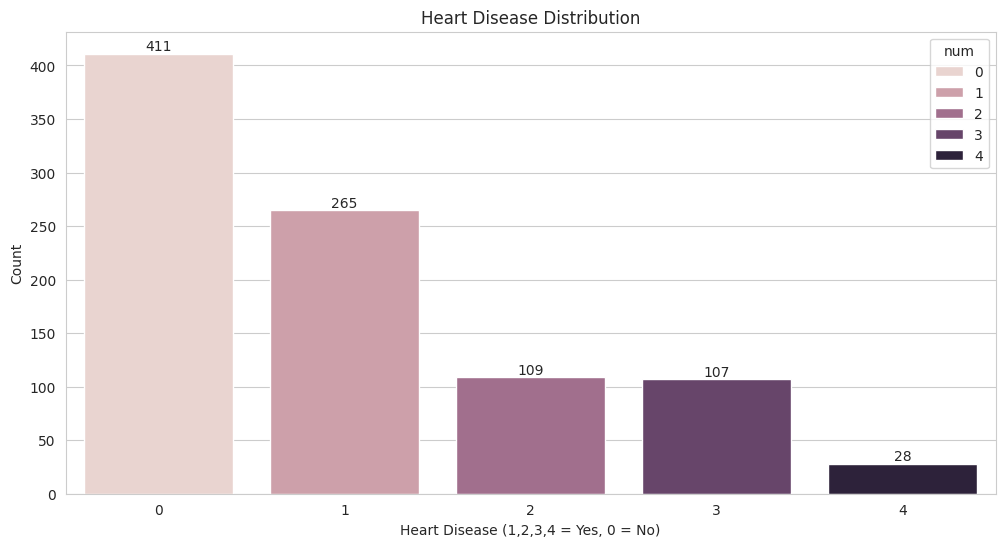

In [50]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='num', hue='num')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)


plt.title('Heart Disease Distribution')
plt.xlabel('Heart Disease (1,2,3,4 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

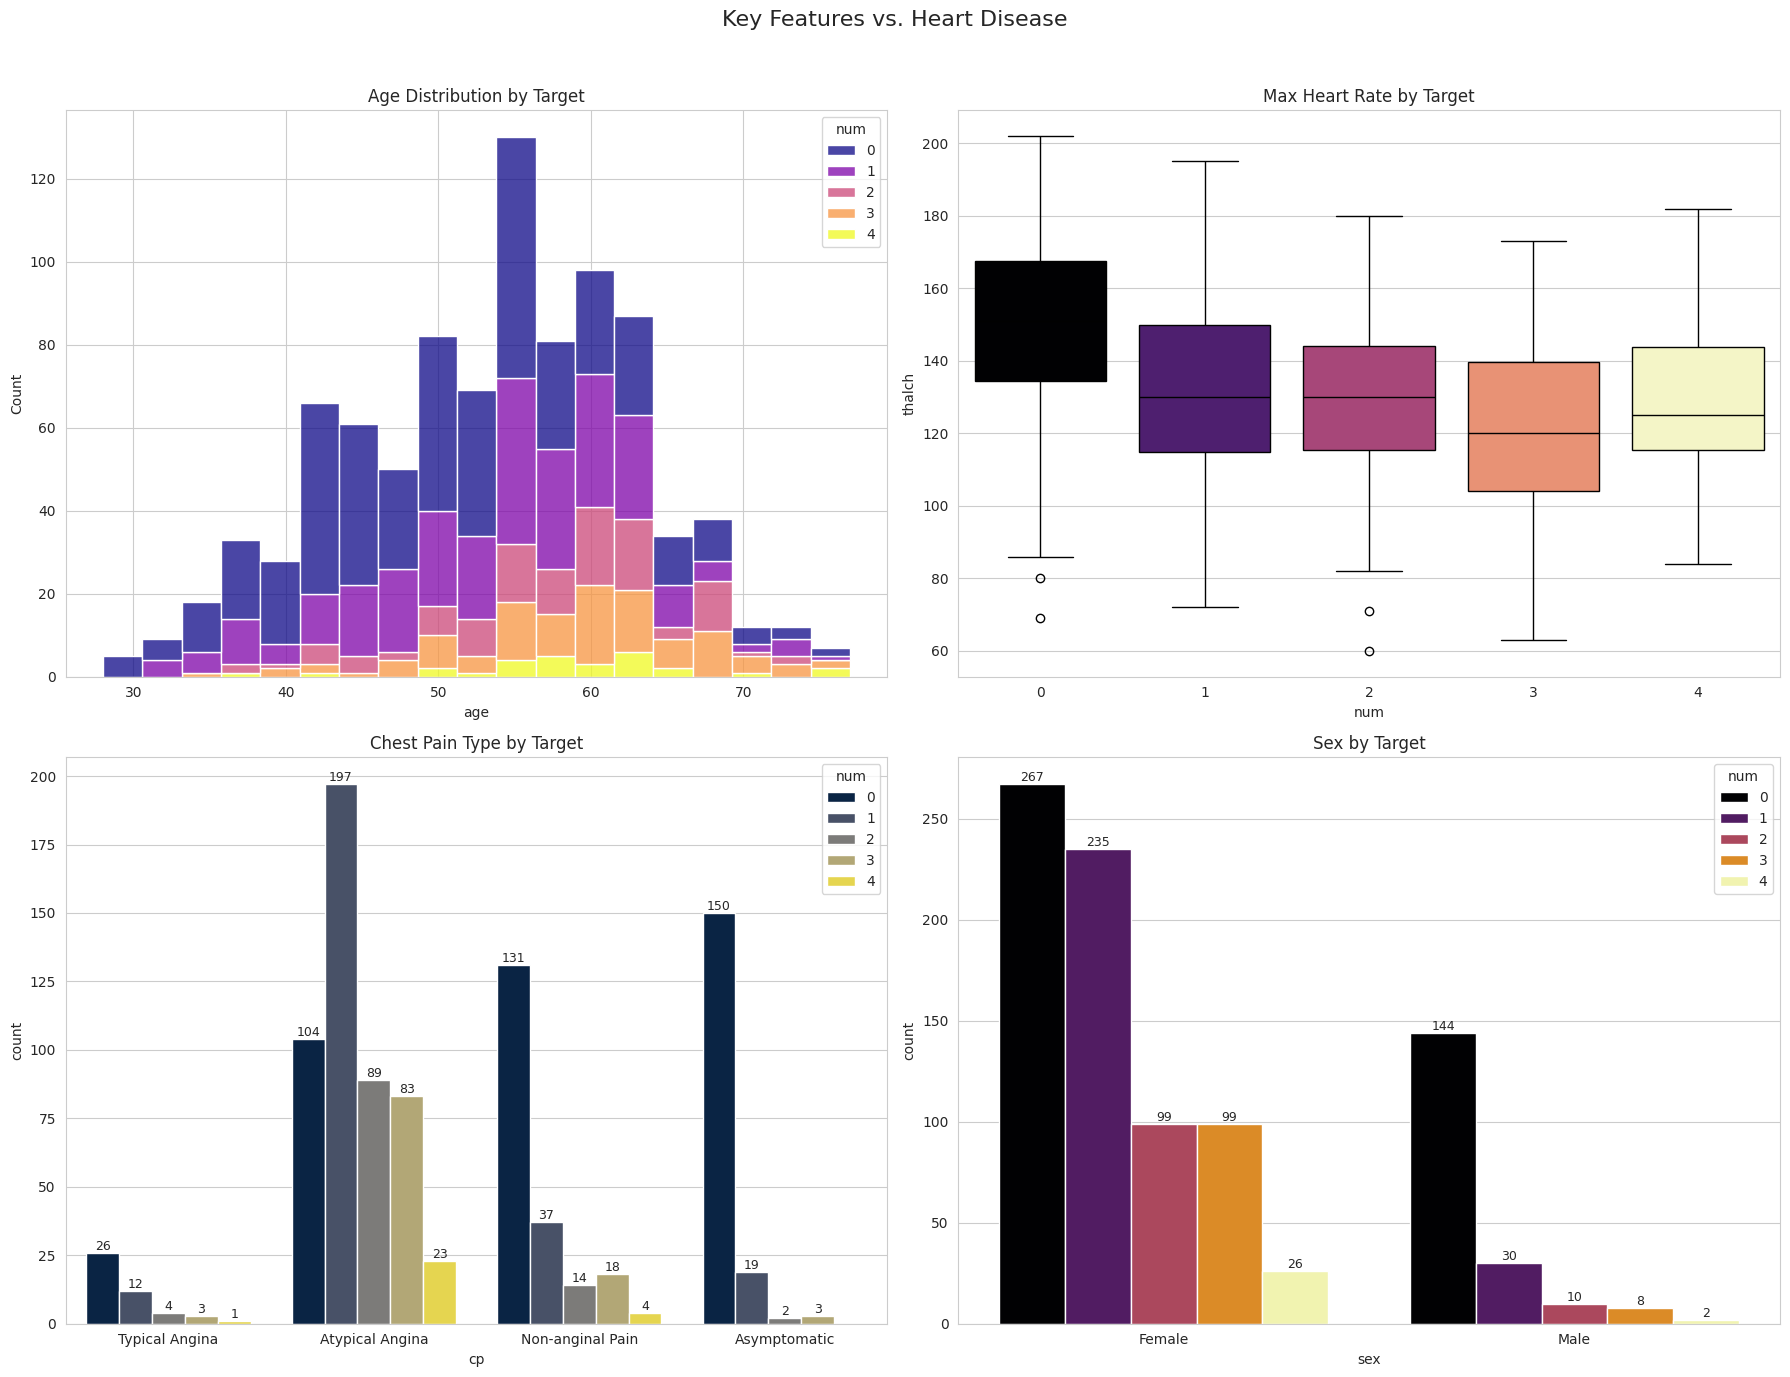

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# 🔑 Add counts to bars
for container in cp_plot.containers:
    cp_plot.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

# 🔑 Add counts to bars
for container in sex_plot.containers:
    sex_plot.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

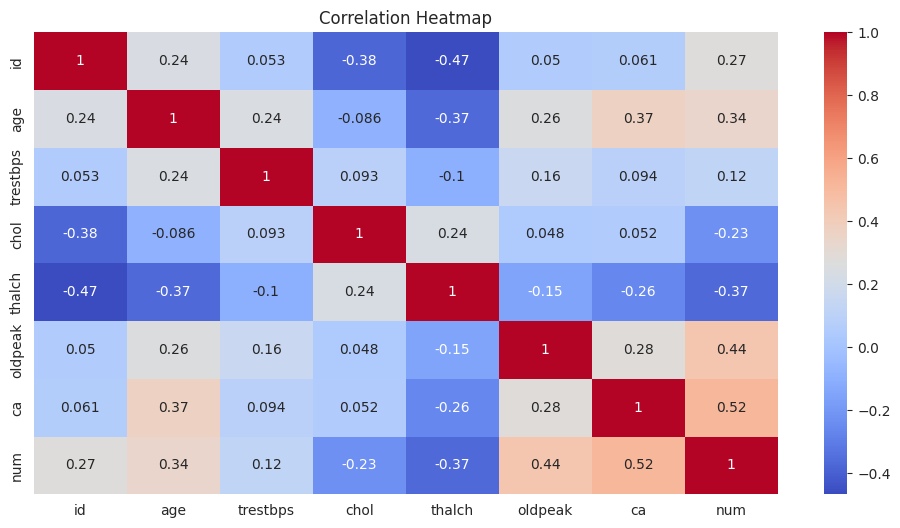

In [52]:
numerical_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(12, 6))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### 3. Data Cleaning & EDA

In [53]:
df.isna().sum()
df.set_index('id', inplace=True)

In [54]:
X = df.drop('num', axis=1)
y = df['num']

In [55]:
numerical_columns = X.select_dtypes(include=np.number).columns
categorical_columns = X.select_dtypes(include=object).columns
print("Numerical Columns:")
print(numerical_columns)
print("\nCategorical Columns:")
print(categorical_columns)

Numerical Columns:
Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca'], dtype='object')

Categorical Columns:
Index(['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], dtype='object')


In [56]:
### For continuous numerical values with skewed data
numeric_cols = ['trestbps', 'chol', 'thalch', 'oldpeak']
for col in numeric_cols:
  if col in X.columns:
    X[col].fillna(X[col].median(), inplace=True)

### Dropping ca as it's mostly values are missing
X = X.drop(columns=['ca'])
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

/tmp/ipython-input-1463576508.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)


In [57]:
numerical_columns = X.select_dtypes(include=np.number).columns
X[numerical_columns].isna().sum()

,0
age,0
trestbps,0
chol,0
thalch,0
oldpeak,0


In [58]:
X.drop(columns=['dataset'], axis=1, inplace=True)
categorical_columns = X.select_dtypes(include=object).columns

for col in categorical_columns:
  if col in X.columns:
    X[col].fillna(X[col].mode()[0], inplace=True)


/tmp/ipython-input-1369478026.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mode()[0], inplace=True)
/tmp/ipython-input-1369478026.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col].fillna(X[col].mode()[0], inplace=True)


In [59]:
# Handle parameter name change
encoder_params = {}
if sklearn.__version__ >= "1.2":
    encoder_params["sparse_output"] = False
else:
    encoder_params["sparse"] = False

one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', **encoder_params)

# Fit and transform categorical data
encoded = one_hot_encoder.fit_transform(X[categorical_columns])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns))

# Concatenate with numeric features
X = pd.concat(
    [X.drop(columns=categorical_columns).reset_index(drop=True),
     encoded_df.reset_index(drop=True)], axis=1
)

print(X.shape)


(920, 17)


In [60]:
X.head(5)

,age,trestbps,chol,thalch,oldpeak,sex_Male,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,63,0.705176,0.303643,0.489727,1.368109,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67,1.518569,0.789967,-1.181478,0.611589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,67,-0.650479,0.266939,-0.345875,1.651804,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,37,-0.108217,0.459634,1.961979,2.502889,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,41,-0.108217,0.037541,1.365120,0.517024,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5. Model Training

In [62]:
from sklearn.svm import SVC

###    LogisticRegression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train, )
lr_pred = lr_model.predict(X_test)


###   RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

###   Support Vector Machine
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)


###   K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, lr_pred, zero_division=0))

print("\n--- Random Forest Performance ---")
print(classification_report(y_test, rf_pred, zero_division=0))

print("\n--- Support Vector Machine (SVM) Performance ---")
print(classification_report(y_test, svm_pred, zero_division=0))

print("\n--- K-Nearest Neighbors (KNN) Performance ---")
print(classification_report(y_test, knn_pred, zero_division=0))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        75
           1       0.44      0.56      0.49        54
           2       0.14      0.04      0.06        25
           3       0.31      0.15      0.21        26
           4       0.00      0.00      0.00         4

    accuracy                           0.54       184
   macro avg       0.31      0.32      0.30       184
weighted avg       0.47      0.54      0.49       184


--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        75
           1       0.48      0.54      0.50        54
           2       0.33      0.16      0.22        25
           3       0.21      0.12      0.15        26
           4       0.00      0.00      0.00         4

    accuracy                           0.57       184
   macro avg       0.35      0.34      0.33       184
we

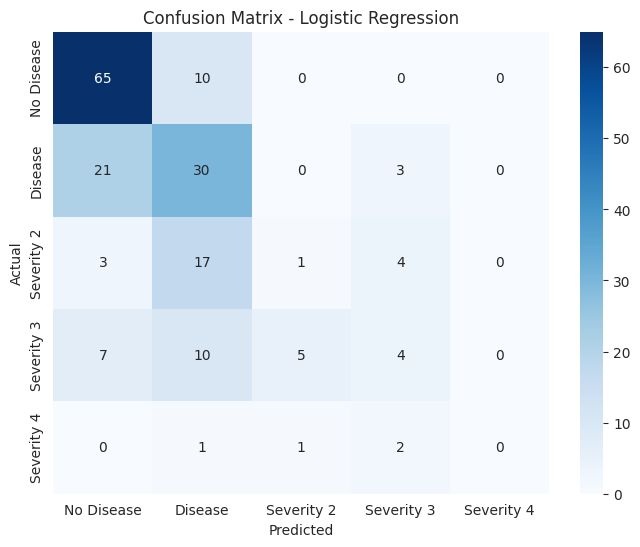

In [64]:
# Visualize the confusion matrix for the best model (SVM)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'], yticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()